## Computational Workflow Schematic
![Computational Workflow Schematic](images/fig_3.png)

# Insulator classification and Band gap Regression models for Double Oxide Perovskites
We implement two models in this notebook.


## i) Classification model 
- To separate materials that have a bandgap greater than 0.5 eV (Insulators) from those that have a very narrow band gap ( < 0.5 eV).

## ii) Regression model 
- To predict the band gap of materials classified by (i) as insulators

### Since we are working with large datasets, we use the python [pickle](https://docs.python.org/3/library/pickle.html) module to manage our dataset.

In [1]:
import pickle
import pandas as pd
import engine as en
from data_utilities.generate_data import generate_feature_labels, csv_to_json, prepare_data

### We load our training compounds, element data and candidate compounds

In [2]:
with open('datasets/training_compounds.pkl', 'rb') as f:
                training_compounds = pickle.load(f)
with open('datasets/element_data.pkl', 'rb') as f:
                ele_data = pickle.load(f)

In [ ]:
ele_data['Al'].keys()

In [ ]:
training_compounds[10].keys()

### Populate the training data

In [3]:
dft_training_data = en.create_perovskite_stability_training_data(training_compounds, ele_data)

In [ ]:
training_compounds[10].keys()

### Run the classification model

------------------------------------------------------------------------
Insulator classification Model Performance
------------------------------------------------------------------------
RFC Test Precision: 0.9236641221374046
RFC Test Recall: 0.8581560283687943
RFC Test Accuracy: 0.9418604651162791
Test confusion matrix
[[365  10]
 [ 20 121]]
Train confusion matrix
[[3200    2]
 [  15 1419]]
 All data confusion matrix
[[3565   12]
 [  35 1540]]
------------------------------------------------------------------------


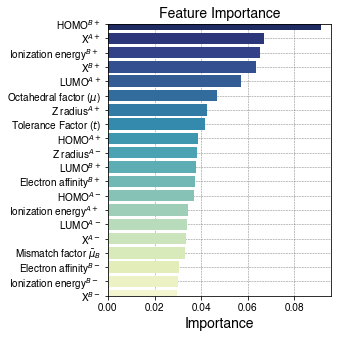

In [4]:
insulator_feature_list, test_features,test_labels,insulator_clf = en.run_insulator_classification(dft_training_data)

## Analyze the classification model

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       375
           1       0.92      0.86      0.89       141

    accuracy                           0.94       516
   macro avg       0.94      0.92      0.93       516
weighted avg       0.94      0.94      0.94       516



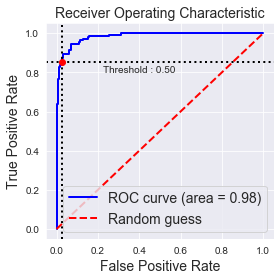

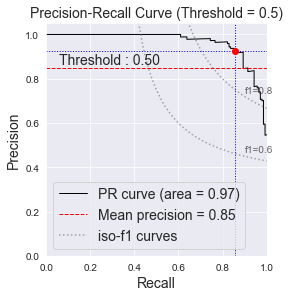

In [5]:
from ML_utilities.ML_plotting import plot_roc_curves
plot_roc_curves(test_features,test_labels, insulator_clf)

In [6]:
bandgap_training_data = en.create_bandgap_regression_training_data(training_compounds, ele_data)

## Extract the training data for band gap regression

## Plot the training data

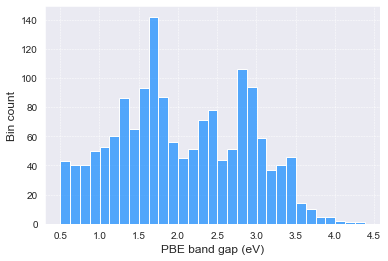

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plot_data = pd.DataFrame(bandgap_training_data)
fig, ax = plt.subplots()
b = sns.histplot(data=plot_data, x="PBE_band_gap",binwidth=0.125,color='dodgerblue',edgecolor="white") 
b.tick_params(labelsize=10)
plt.xlabel('PBE band gap (eV)',fontsize=12) 
plt.ylabel('Bin count',fontsize=12) 
plt.grid(linestyle='--', linewidth='0.5')

## Run band gap regression model

------------------------------------------------------------------------
Band gap regression Model Performance
------------------------------------------------------------------------
Band gap regression Training
MSE: 0.0186
MAE: 0.0821
R2_coefficient: 0.9732
------------------------------------------------------------------------
Band gap regression Test
MSE: 0.3296
MAE: 0.2005
R2_coefficient: 0.8197
------------------------------------------------------------------------


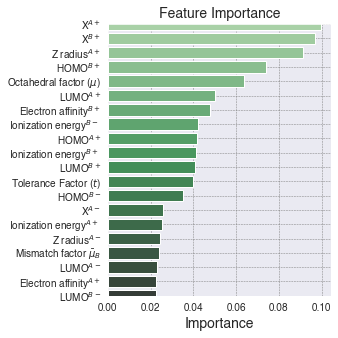

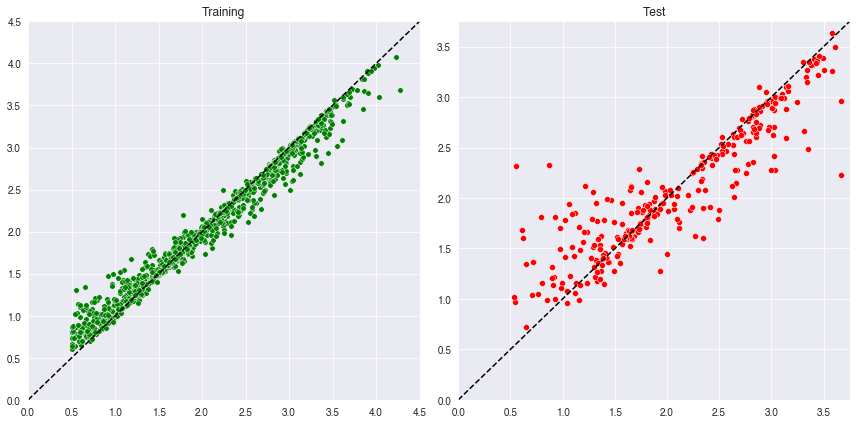

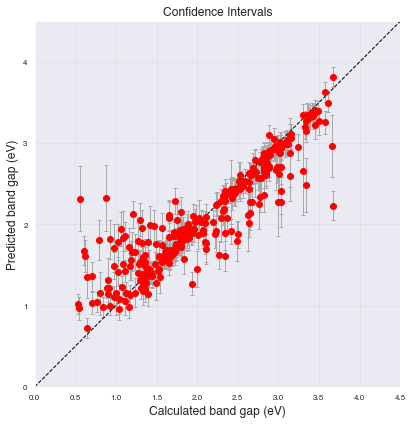

In [8]:
regression_feature_list, best_estimator = en.run_bandgap_regression(bandgap_training_data)

## Predict new oxide perovskites with wide band gap

In [9]:
all_candidates = csv_to_json('datasets/stable_formable_candidates.csv')
all_candidate_data = prepare_data(all_candidates,ele_data)

In [10]:
len(all_candidate_data)

476291

In [11]:
from ML_utilities.RFC_functions import classify_data
insulator_candidates = classify_data(all_candidate_data, insulator_feature_list, insulator_clf, pred_label='predicted_Insulator', data_type='prediction', model_type='insulator')

Classify candidates
Number of compounds: 476291
Number of classified True compounds: 16949


### Of the 1350216 candidates, 16950 are predicted to be insulators

In [12]:
from ML_utilities.RFR_functions import predict_regression
wide_bandgap_data = predict_regression(insulator_candidates, regression_feature_list, best_estimator, pred_label='Predicted_band_gap')

Number of compounds: 16949
Number of wide bandgap compounds: 16949


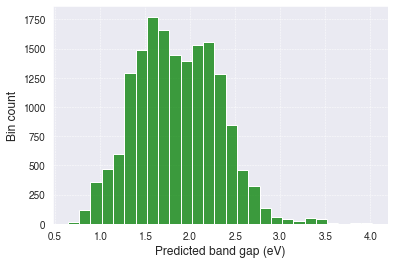

In [13]:
plot_data = pd.DataFrame(wide_bandgap_data)
fig, ax = plt.subplots()
b = sns.histplot(data=plot_data, x="Predicted_band_gap",binwidth=0.125,color='green',edgecolor="white") 
b.tick_params(labelsize=10)
plt.xlabel('Predicted band gap (eV)',fontsize=12) 
plt.ylabel('Bin count',fontsize=12) 
plt.grid(linestyle='--', linewidth='0.5')

## More analysis: Partial Dependence Plots (PDPs)

In [14]:
importances = list(best_estimator.feature_importances_)
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(regression_feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
ranked_features = []
for i in range(5):
    ranked_features.append(feature_importances[i][0])	
dataset = pd.DataFrame(bandgap_training_data)
ranked_labels = generate_feature_labels(ranked_features)
print(ranked_labels)

['X$^{A+}$', 'X$^{B+}$', 'Z radius$^{A+}$', 'HOMO$^{B+}$', 'Octahedral factor ($\\mu$)']


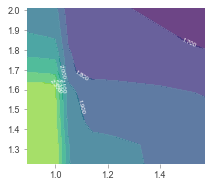

In [15]:
from ML_utilities.ML_plotting import plot_pdp_plots
plot_pdp_plots(best_estimator,dataset,regression_feature_list,ranked_features[0:2],ranked_labels[0:2])